# Uncertainty 

This is a tutorial for the uncertainty module.

## Uncertainty and sensitivity analysis?

Before doing an uncertainty analysis in CLIMADA, it is imperative that you get first comfortable with the different notions of uncertainty in the worl modelling (see e.g. [Douglas-Smith(2020)](https://doi.org/10.1007/978-1-4899-7547-8_5) for a review). In particular, note that the uncertaintity values will only be as good as the input from the user. 

In this module, it is possible to perform global uncertainty analysis, as well as a sensitivity analysis. The word global is meant as opposition to the 'one-factor-at-a-time' (OAT) strategy. The OAT strategy, which consists in analyzing the effect of varying one model input factor at a time while keeping all other fixed, is popular among modellers, but has major shortcomings [Saltelli (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180), [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822) and should not be used.

A rough schemata of how to perform uncertainty and sensitivity analysis (taken from [Saltelli(2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822))

<img src="./img/UncertaintySensitivity.jpg" alt="Uncertainty and Sensitivity analysis">

1. [Douglas-Smith, D., Iwanaga, T., Croke, B. F. W. & Jakeman, A. J. Certain trends in uncertainty and sensitivity analysis: An overview of software tools and techniques. Environmental Modelling & Software 124, 104588 (2020)](https://doi.org/10.1007/978-1-4899-7547-8_5)
2. [Saltelli, A. et al. Why so many published sensitivity analyses are false: A systematic review of sensitivity analysis practices. Environmental Modelling & Software 114, 29–39 (2019)](http://www.sciencedirect.com/science/article/pii/S1364815218302822)
3. [Saltelli, A. & Annoni, P. How to avoid a perfunctory sensitivity analysis. Environmental Modelling & Software 25, 1508–1517 (2010)](https://www.sciencedirect.com/science/article/abs/pii/S1364815210001180)

##  Uncertainty Module Structure

The uncertainty module is contains 2 main classes
- `UncVar`: defines uncertainty variables
- `Uncertainty`: base class to compute uncertainties and sensitivities for CLIMADA outputs.

In addition, there are the child classes of `Uncertainty` defined in their submodules:

- `UncImpact`: specific class to compute uncertainties for outputs of `climada.engine.impact.calc`
- `UncCostBenefit`: specific class to compute uncertainties for outputs of `climada.engine.cost_benefit.calc`

### UncVar 

The UncVar class is used to define uncertainty variables. 

| Attribute | Type | Description |
| --- | --- | --- |
| unc_var | funnction | Variable defined as a function of the uncertainty parameters |
| distr_dict | dict | Dictionary of the probability density distributions of the uncertainty parameters |

An uncertainty parameter is an input value that has a certain distribution in your model, such as the total exposure asset value, the slope the vulnerability function, the exponent of the litpop exposure,  the value of the discount rate, the cost of an adaptation measure, ... 

The distribution of the uncertainty parameters can any of the probability distributions defined in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

#### Example 

Suppose we assume that the GDP value used to scale the exposure has a relative error of +-10%. 

In [12]:
#Define the base exposure
from climada.entity import Exposures
exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

2021-03-18 16:41:01,479 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-18 16:41:01,481 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-18 16:41:01,482 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-18 16:41:01,484 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-18 16:41:01,485 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-18 16:41:01,486 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-18 16:41:01,513 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-18 16:41:01,514 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-18 16:41:01,514 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-18 16:41:01,515 - climada.entity.exposures.base - INF

In [13]:
# Define the function that returns an exposure with scaled total assed value
def exp_func(x_exp, exp_base=exp_base):
    exp = copy.deepcopy(exp_base)
    exp.gdf.value *= x_exp
    return exp

In [15]:
# Define the Uncertainty Variable with +-10% total asset value
from climada.engine.uncertainty import UncVar

exp_distr = {"x_exp": sp.stats.uniform(0.9, 1.1),
              }
exp_unc = UncVar(exp_func, exp_distr)

In [17]:
# Uncertainty parameters
exp_unc.labels

['x_exp']

In [27]:
# Evaluate for a given value of the uncertainty parameters
exp095 = exp_unc.evaluate({'x_exp': 0.95})
print(f"Base value is {exp_base.gdf['value'].sum()}, value for x_exp=0.95 is {exp095.gdf['value'].sum()},"
      f"relative value is {exp095.gdf['value'].sum()/exp_base.gdf['value'].sum()}")

Base value is 657053294559.9105, value for x_exp=0.95 is 624200629831.9148,relative value is 0.9499999999999997


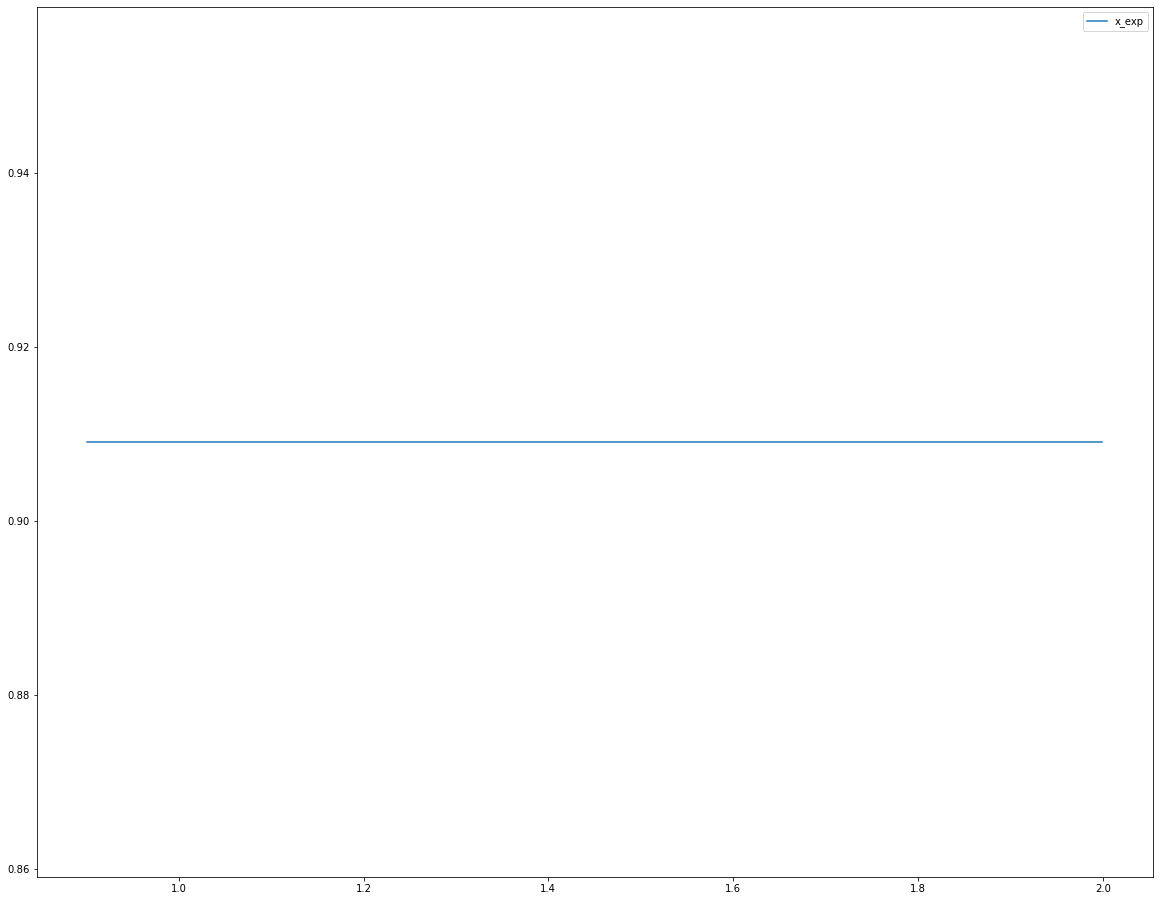

In [20]:
# Defined distribution
exp_unc.plot();

Suppose we want to test different exponents for the LitPop exposure for the country Switzerland.

In [30]:
from climada.entity import LitPop

# Define the function
# Note that this here works, but is suboptimal because the method LitPop is called everytime the the function
# is evaluated. For large countries, LitPop is slow, and it would be better to first create the LitPop 
# Exposure base.
def litpop_cat(m, n):
    exp = Litpop()
    exp.set_country('CHE', exponent=[m, n])
    return exp

#Define the distribution dictionnary
distr_dict = {
    'm': sp.stats.randint(low=0, high=5),
    'n': sp.stats.randint(low=0, high=5)
    }

unc_var_cat = UncVar(litpop_cat, distr_dict)

In [5]:
import copy
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from pathos.pools import ProcessPool as Pool

from climada.engine.uncertainty import UncVar, Uncertainty, UncImpact, UncCostBenefit
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.entity.entity_def import Entity
from climada.hazard import Hazard
from climada.util.value_representation import value_to_monetary_unit as vtm
from climada.util.plot import multibar_plot
from climada.util.constants import EXP_DEMO_H5, HAZ_DEMO_H5, ENT_DEMO_TODAY, ENT_DEMO_FUTURE

In [4]:
def impf_func(G=1, v_half=84.7, vmin=25.7, k=3, _id=1):    
    imp_fun = ImpactFunc()
    imp_fun.haz_type = 'TC'
    imp_fun.id = _id
    imp_fun.intensity_unit = 'm/s'
    imp_fun.intensity = np.linspace(0, 150, num=100)
    imp_fun.mdd = np.repeat(1, len(imp_fun.intensity))
    imp_fun.paa = np.array([sigmoid_func(v, G, v_half, vmin, k) for v in imp_fun.intensity])
    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

def xhi(v, v_half, vmin):
    return max([(v - vmin), 0]) / (v_half - vmin)
  
def sigmoid_func(v, G, v_half, vmin, k):
    return G * xhi(v, v_half, vmin)**k / (1 + xhi(v, v_half, vmin)**k)

exp_base = Exposures()
exp_base.read_hdf5(EXP_DEMO_H5)

def exp_func(x_exp, exp_base=exp_base):
    exp = copy.deepcopy(exp_base)
    exp.gdf.value *= x_exp
    exp.check()
    return exp

haz_base = Hazard()
haz_base.read_hdf5(HAZ_DEMO_H5)

2021-03-18 15:48:22,863 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-18 15:48:22,870 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-18 15:48:22,874 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-18 15:48:22,875 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-18 15:48:22,897 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-18 15:48:22,898 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5
2021-03-18 15:48:22,985 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-18 15:48:22,986 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-18 15:48:22,987 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-18 15:48:22,987 - climada.entity.exposures.base - INF

## Impact uncertainty and sensitivity analysis

In [39]:
exp = exp_func
exp_distr = {"x_exp": sp.stats.beta(0.8, 1.2),
              }
exp_unc = UncVar(exp, exp_distr)

impf = impf_func
impf_distr = {
    "G": sp.stats.truncnorm(0.8,1.2),
    "v_half": sp.stats.uniform(35, 100),
    "vmin": sp.stats.uniform(0, 15),
    "k": sp.stats.uniform(1, 5)
    }
impf_unc = UncVar(impf, impf_distr)

haz = haz_base

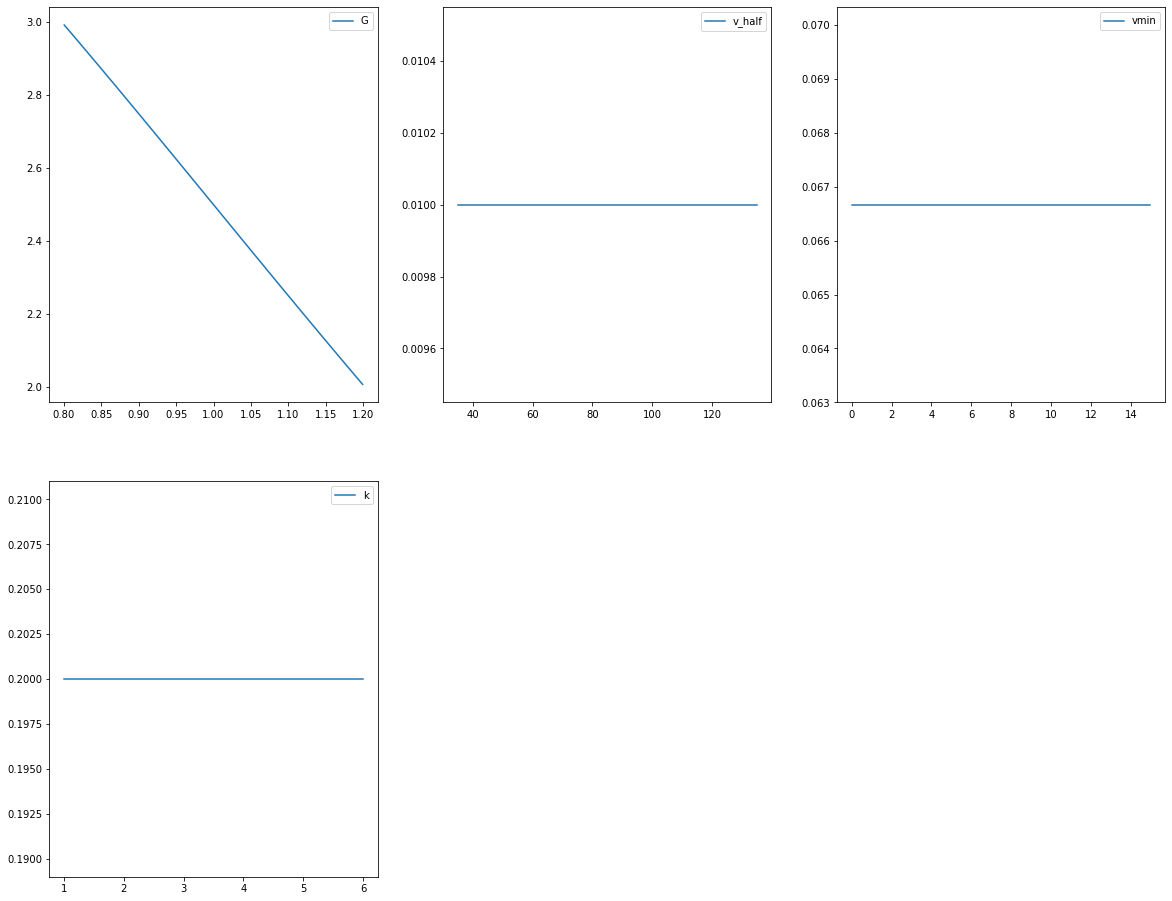

In [40]:
impf_unc.plot();

### Example using the default values for all methods 

In [41]:
unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=100, sampling_method='saltelli', sampling_kwargs = {'calc_second_order': False})

2021-03-05 16:15:18,881 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 700


,x_exp,G,v_half,vmin,k
0,0.125521,0.832731,86.855469,10.151367,2.401367
1,0.833040,0.832731,86.855469,10.151367,2.401367
2,0.125521,0.815430,86.855469,10.151367,2.401367
3,0.125521,0.832731,124.941406,10.151367,2.401367
4,0.125521,0.832731,86.855469,7.514648,2.401367
...,...,...,...,...,...
695,0.326540,0.853179,91.494141,1.560059,5.855957
696,0.326540,1.015208,41.396484,1.560059,5.855957
697,0.326540,1.015208,91.494141,11.037598,5.855957
698,0.326540,1.015208,91.494141,1.560059,4.239746


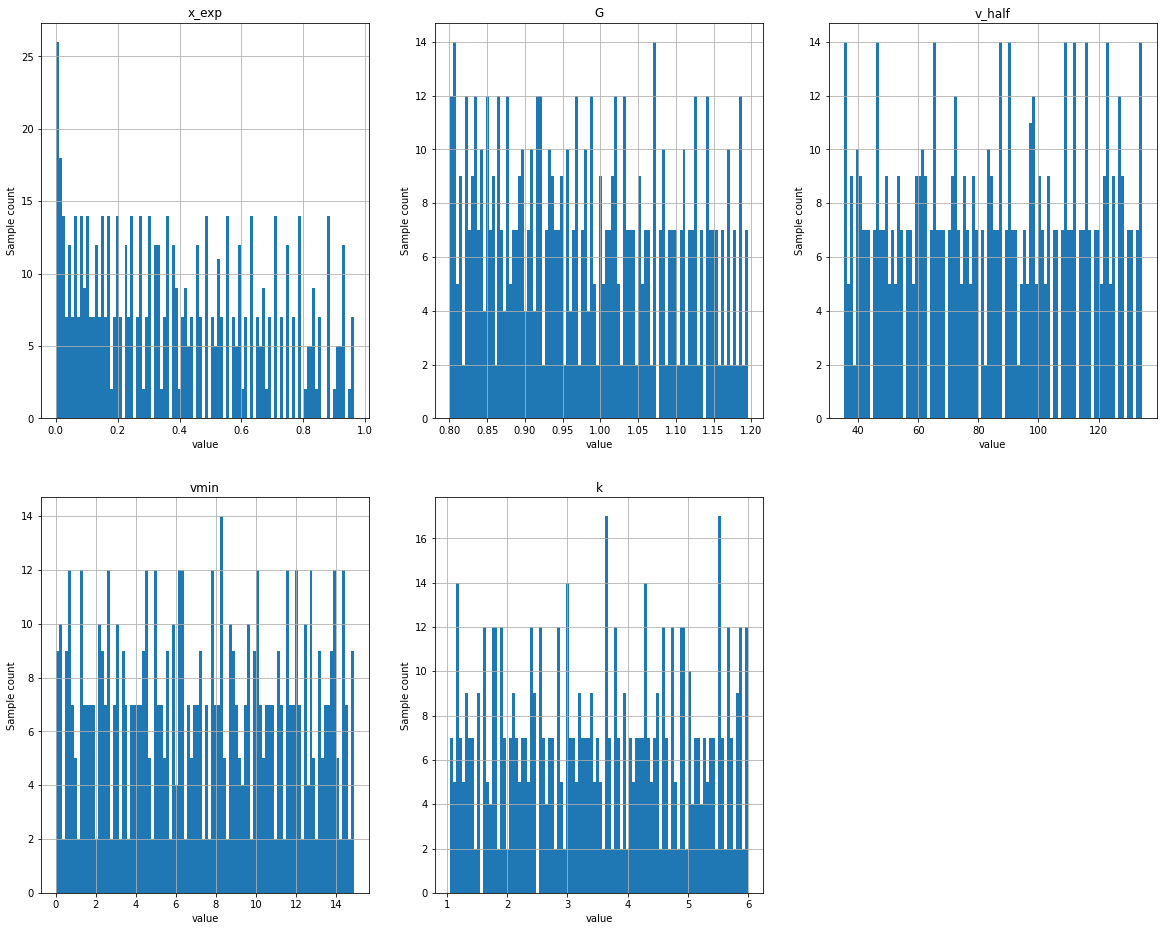

In [42]:
unc.plot_sample();

In [43]:
unc.calc_distribution(rp = [50, 100, 250])

2021-03-05 16:15:20,133 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-05 16:15:20,137 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-05 16:15:20,138 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-05 16:15:20,146 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-05 16:15:20,153 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 16.169999999999998s



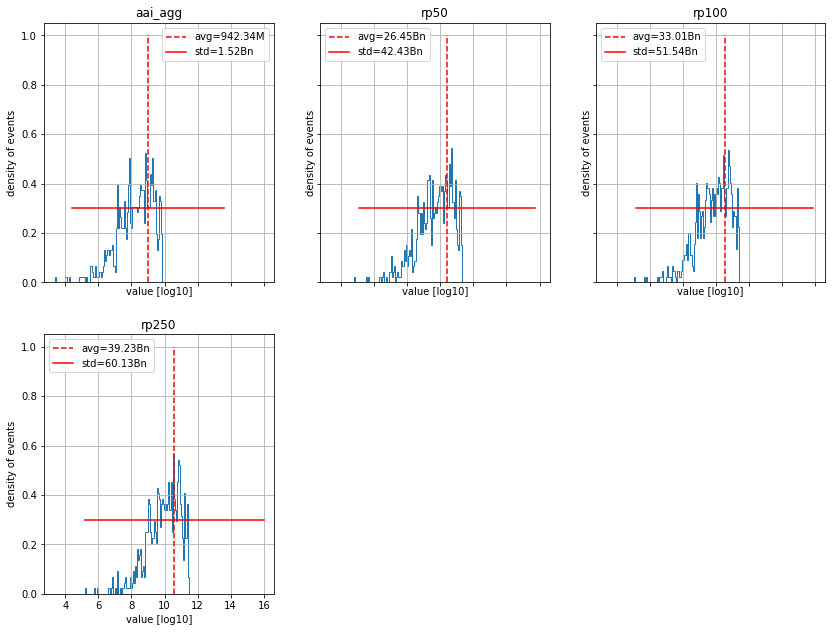

In [44]:
unc.plot_distribution(metric_list=['aai_agg', 'freq_curve']);

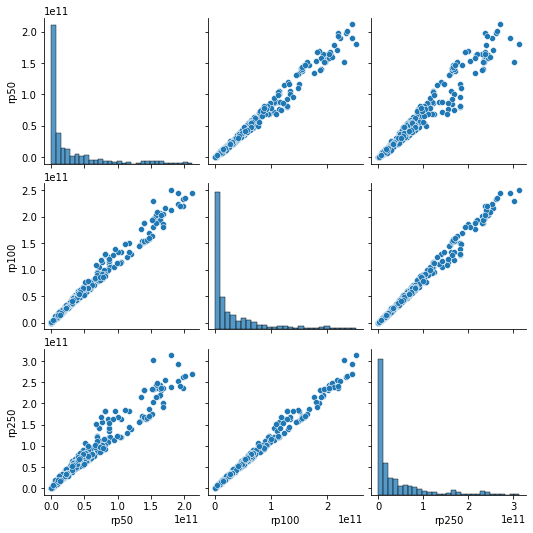

In [45]:
freq_curve = unc.metrics['freq_curve']
sns.pairplot(freq_curve);

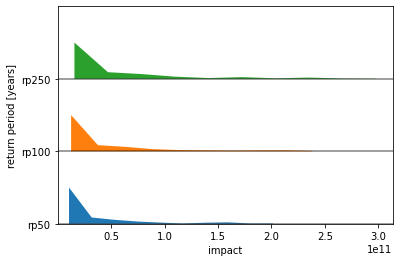

In [46]:
unc.plot_rp_distribution();

In [47]:
unc.calc_sensitivity(salib_method='sobol', method_kwargs = {'conf_level' : 0.95, 
                                                           'calc_second_order': False})

{'aai_agg': {'aai_agg': {'S1': array([0.35318387, 0.02888573, 0.29028966, 0.00244575, 0.07365607]),
   'S1_conf': array([0.17529277, 0.03517684, 0.23149159, 0.02231224, 0.11929488]),
   'ST': array([0.45797138, 0.02597843, 0.58556506, 0.01358738, 0.2763128 ]),
   'ST_conf': array([0.20323551, 0.0166112 , 0.31003591, 0.00758573, 0.15210865])}},
 'freq_curve': {'rp50': {'S1': array([0.35762565, 0.02671238, 0.30429953, 0.00039749, 0.07185341]),
   'S1_conf': array([0.18972764, 0.03899618, 0.20580599, 0.02112991, 0.13391749]),
   'ST': array([0.4598212 , 0.02464501, 0.61748473, 0.01009205, 0.23096831]),
   'ST_conf': array([0.23502657, 0.01562591, 0.33766392, 0.0065157 , 0.14402084])},
  'rp100': {'S1': array([3.68793718e-01, 2.63885339e-02, 3.39009260e-01, 2.81072504e-04,
          5.76714553e-02]),
   'S1_conf': array([0.17063804, 0.04432416, 0.23157515, 0.01378893, 0.11192182]),
   'ST': array([0.4745089 , 0.02347709, 0.71585254, 0.0063869 , 0.16279755]),
   'ST_conf': array([0.1953473 

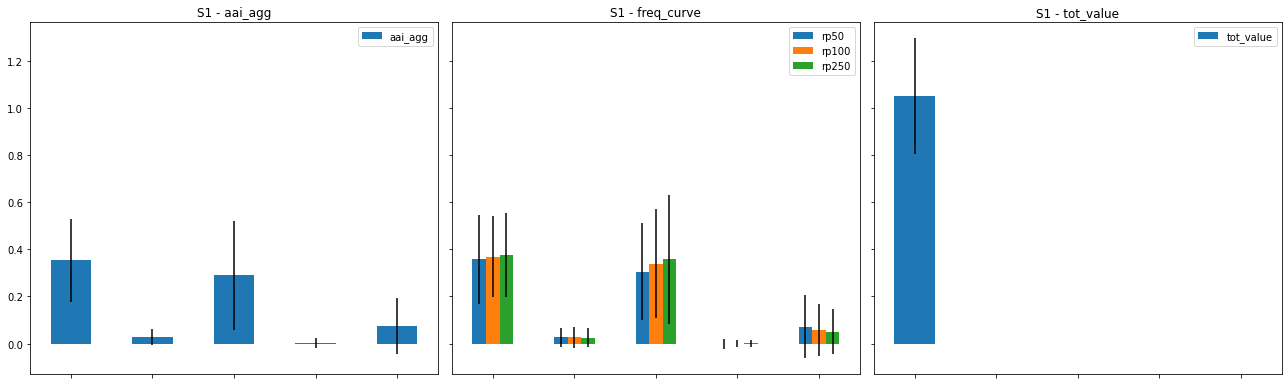

In [48]:
unc.plot_sensitivity();

### Different Salib method 

In [49]:
unc = UncImpact(exp_unc, impf_unc, haz)
unc.make_sample(N=100, sampling_method='latin')

2021-03-05 16:15:30,747 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 100


,x_exp,G,v_half,vmin,k
0,0.834941,0.846536,86.335688,11.114022,3.456025
1,0.318263,0.887897,38.348157,2.899003,1.843364
2,0.281322,0.824986,51.343855,5.838540,3.561908
3,0.004032,1.158169,126.212002,9.041936,2.608376
4,0.141698,0.869180,73.184722,9.778151,4.575570
...,...,...,...,...,...
95,0.895257,0.912970,120.120380,0.407957,3.934892
96,0.838480,1.045294,41.099363,4.384443,2.092723
97,0.801707,1.085927,133.989928,3.904060,1.004676
98,0.760685,0.958645,115.847732,11.680385,1.897609


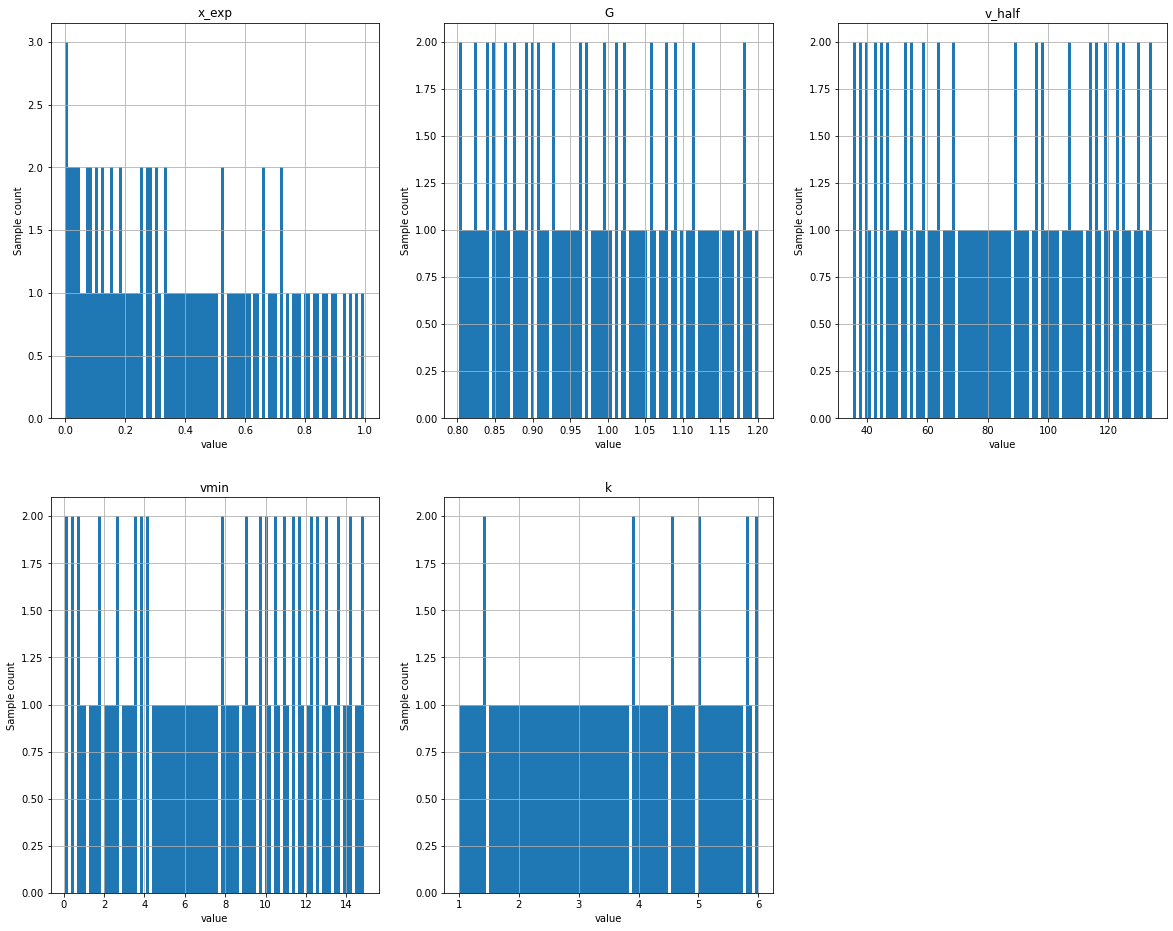

In [50]:
unc.plot_sample();

In [51]:
unc.calc_distribution(rp = [50, 100, 250], )

2021-03-05 16:15:32,118 - climada.entity.exposures.base - INFO - centr_ not set.
2021-03-05 16:15:32,120 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-03-05 16:15:32,122 - climada.entity.exposures.base - INFO - Matching 50 exposures with 2500 centroids.
2021-03-05 16:15:32,129 - climada.engine.impact - INFO - Calculating damage for 50 assets (>0) and 216 events.
2021-03-05 16:15:32,135 - climada.engine.uncertainty.unc_impact - INFO - 

Estimated computation time: 2.08s



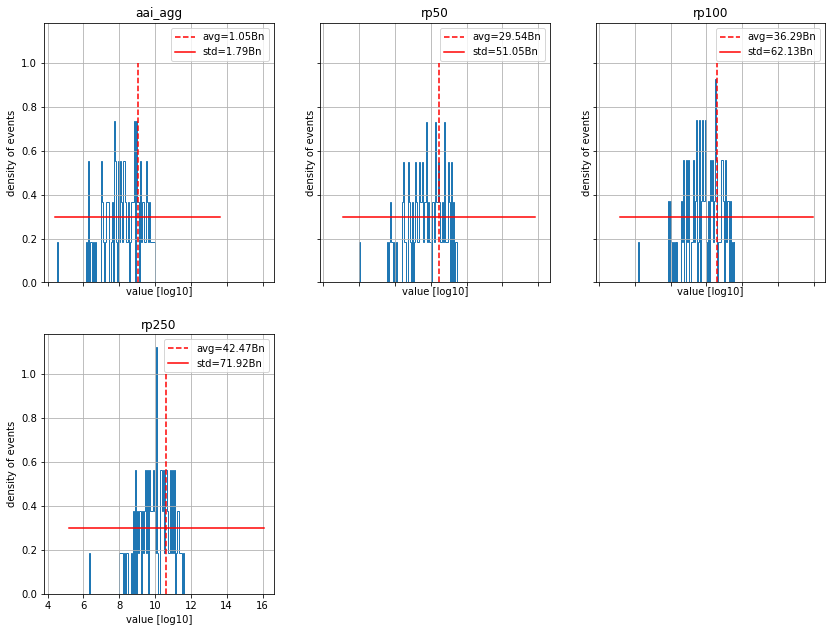

In [52]:
unc.plot_distribution(metric_list=['aai_agg', 'freq_curve']);

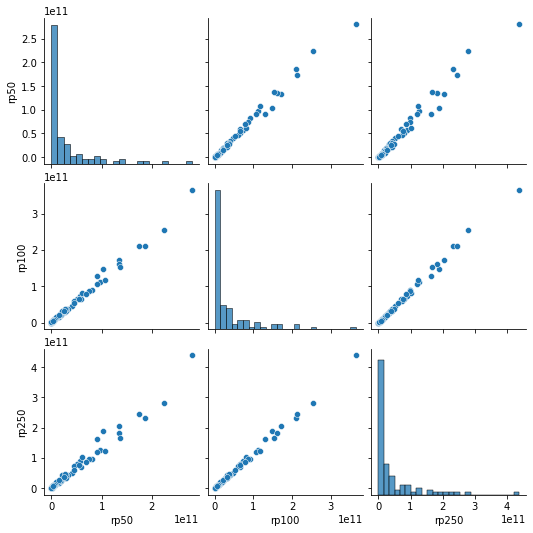

In [53]:
freq_curve = unc.metrics['freq_curve']
sns.pairplot(freq_curve);

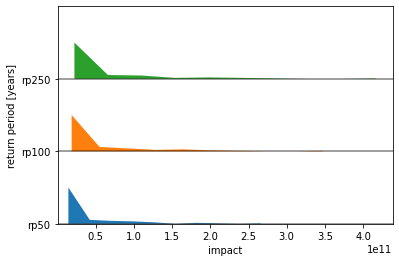

In [54]:
unc.plot_rp_distribution();

In [55]:
unc.calc_sensitivity(salib_method='rbd_fast', method_kwargs = {'M': 15})

{'aai_agg': {'aai_agg': {'S1': [0.04644177434287955,
    -0.1039276905290655,
    0.5106917086606744,
    -0.16897249528680358,
    0.07259397303765386],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'freq_curve': {'rp50': {'S1': [0.047961950333668846,
    -0.10722709552072454,
    0.5315246177874814,
    -0.1701065467053979,
    0.0522395304203942],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp100': {'S1': [0.04913790657082773,
    -0.11390412099929204,
    0.567913925982113,
    -0.1695845484724345,
    0.02534011060394259],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']},
  'rp250': {'S1': [0.05222964699193855,
    -0.11777479185776027,
    0.5867941711167849,
    -0.16811800686824063,
    0.010184768711696768],
   'names': ['x_exp', 'G', 'v_half', 'vmin', 'k']}},
 'eai_exp': {},
 'at_event': {},
 'tot_value': {'tot_value': {'S1': [0.999718910871201,
    -0.09346530032190975,
    0.11561485691458612,
    -0.11931481657529616,
    0.05343487188185225],
   'name

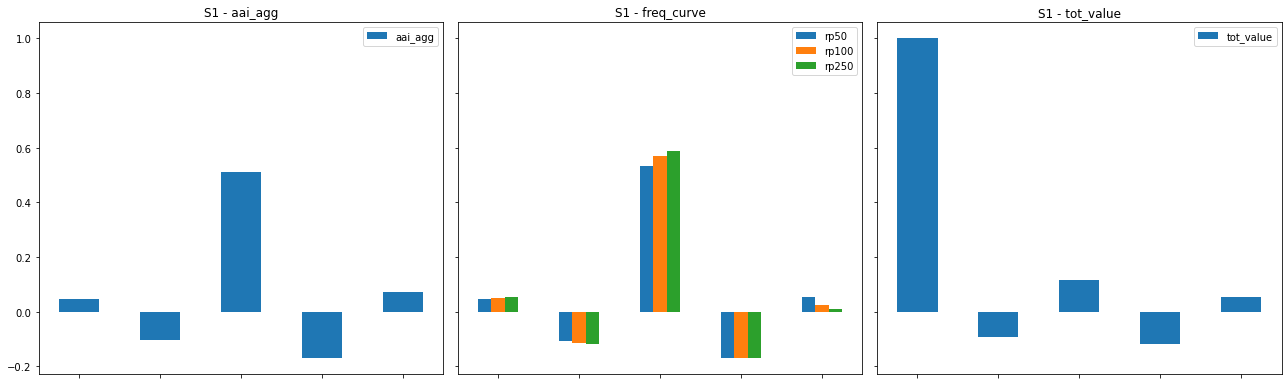

In [56]:
unc.plot_sensitivity();

## Cost Benefit uncertainty and sensitivity analysis

In [61]:
def ent_today(x_ent):
    entity = Entity()
    entity.read_excel(ENT_DEMO_TODAY)
    entity.exposures.ref_year = 2018
    entity.exposures.gdf.value *= x_ent
    entity.check()
    return entity

def ent_future():
    entity = Entity()
    entity.read_excel(ENT_DEMO_FUTURE)
    entity.exposures.ref_year = 2040
    entity.check()
    return entity

def haz_fut_func(x_haz_fut, haz_base=haz_base):
    haz = copy.deepcopy(haz_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz


In [62]:
haz = haz_base

haz_distr = {"x_haz_fut": sp.stats.uniform(1, 3),
              }
haz_fut_unc = UncVar(haz_fut_func, haz_distr)

ent_distr = {"x_ent":  sp.stats.uniform(0.7, 1)}
ent_unc = UncVar(ent_today, ent_distr)

ent_fut = ent_future()

2021-03-05 16:18:03,430 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,431 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,432 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,433 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,434 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-05 16:18:03,468 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,469 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,469 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,470 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,471 - climada.entity.exposures.base - INFO - crs set to default

In [63]:
unc = UncCostBenefit(haz_unc=haz, ent_unc=ent_unc,
                     haz_fut_unc=haz_fut_unc, ent_fut_unc=ent_fut)
unc.make_sample(N=10)
unc.sample.head()

2021-03-05 16:18:03,618 - climada.engine.uncertainty.base - INFO - Effective number of made samples: 60


,x_ent,x_haz_fut
0,0.919727,1.290039
1,1.218555,1.290039
2,0.919727,3.030273
3,0.919727,3.030273
4,1.218555,1.290039


In [64]:
pool = Pool()
unc.calc_distribution(pool=pool)
pool.close()
pool.join()
pool.clear()

2021-03-05 16:18:03,631 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,632 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,633 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,634 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,635 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326
2021-03-05 16:18:03,666 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-03-05 16:18:03,667 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-03-05 16:18:03,667 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-03-05 16:18:03,668 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-03-05 16:18:03,669 - climada.entity.exposures.base - INFO - crs set to default

In [65]:
macro_metrics = list(unc.metrics.keys())
macro_metrics

['tot_climate_risk',
 'benefit',
 'cost_ben_ratio',
 'imp_meas_present',
 'imp_meas_future']

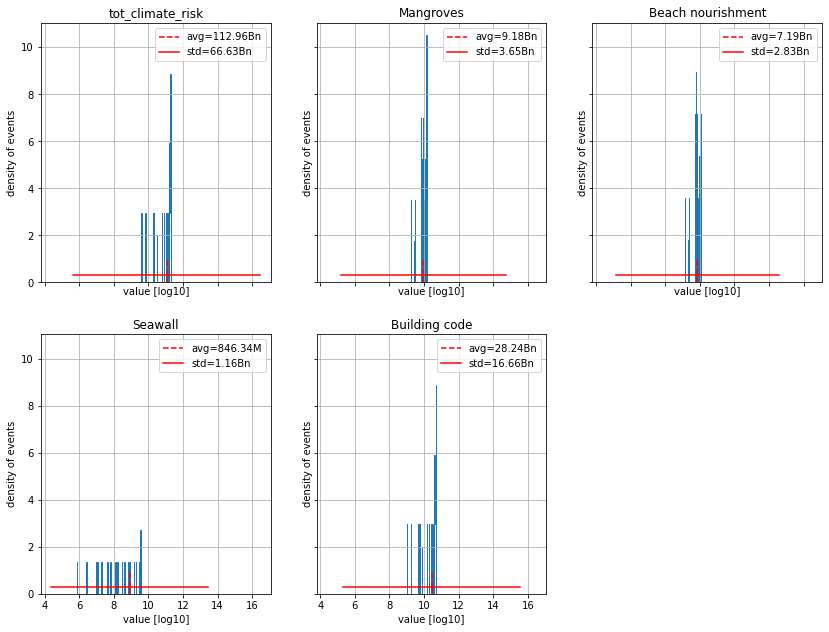

In [66]:
unc.plot_distribution(metric_list=['tot_climate_risk', 'benefit']);

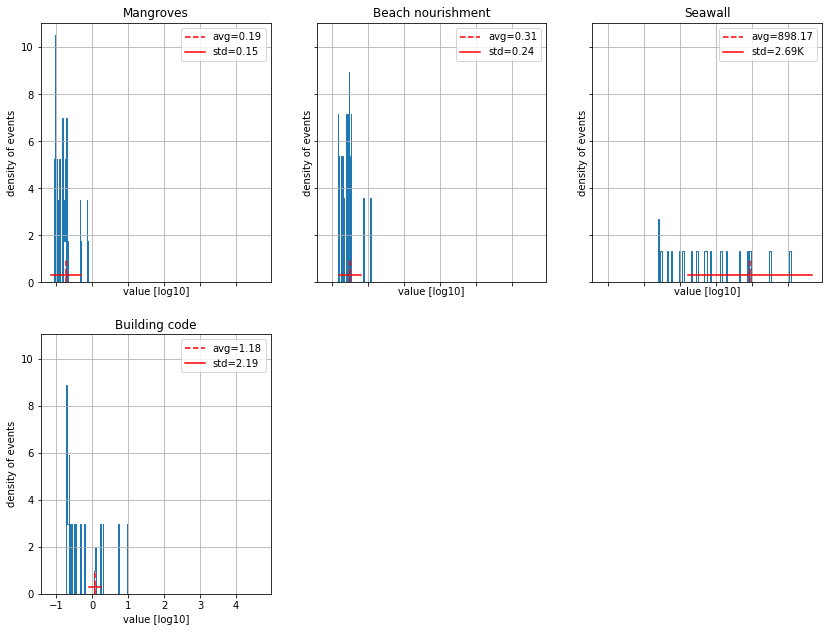

In [67]:
unc.plot_distribution(metric_list=['cost_ben_ratio'], );

In [68]:
unc.calc_sensitivity()

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:142: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib/analyze/sobol.py:148: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/SALib

{'tot_climate_risk': {'tot_climate_risk': {'S1': array([0.0018922 , 0.80416505]),
   'S1_conf': array([0.00298371, 0.60869264]),
   'ST': array([9.70209053e-06, 8.34154299e-01]),
   'ST_conf': array([1.25990287e-05, 4.78951001e-01]),
   'S2': array([[        nan, -0.00376499],
          [        nan,         nan]]),
   'S2_conf': array([[      nan, 0.0059521],
          [      nan,       nan]])}},
 'benefit': {'Mangroves': {'S1': array([0.01246896, 1.33346589]),
   'S1_conf': array([0.02074035, 0.83737701]),
   'ST': array([7.98637483e-04, 1.15435338e+00]),
   'ST_conf': array([0.00100091, 0.34090604]),
   'S2': array([[        nan, -0.02334064],
          [        nan,         nan]]),
   'S2_conf': array([[       nan, 0.03978184],
          [       nan,        nan]])},
  'Beach nourishment': {'S1': array([0.01232256, 1.35383812]),
   'S1_conf': array([0.02622251, 0.92865791]),
   'ST': array([8.83987380e-04, 1.20059475e+00]),
   'ST_conf': array([0.0013722 , 0.38086757]),
   'S2': arr

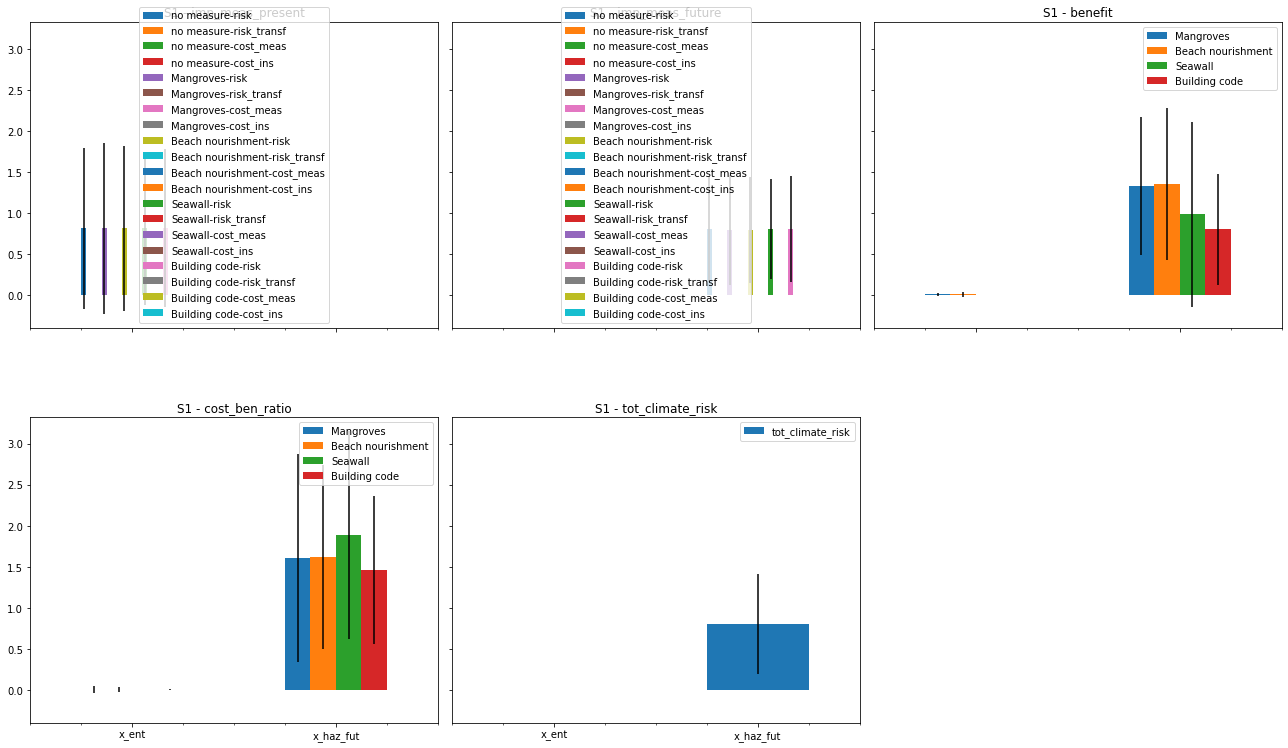

In [69]:
unc.plot_sensitivity();